<a href="https://colab.research.google.com/github/aayushhyadav/MIA/blob/feature%2Fmnist/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [2]:
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
import math

In [14]:
'''
  # loads mnist dataset
  # flattens the dataset
  # performs one hot encoding on target values
'''
def load_dataset():
  (train_X, train_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()
  
  class_examples_train = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  class_examples_test = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

  for example in train_y:
    class_examples_train[example] += 1
  for example in test_y:
    class_examples_test[example] += 1

  for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(train_X[i], cmap='gray')
  plt.show()

  print(f'class distribution for training dataset - {class_examples_train}')
  print(f'class distribution for testing dataset - {class_examples_test}')

  flat_train_X = train_X.reshape((train_X.shape[0], 28, 28, 1))
  flat_test_X = test_X.reshape((test_X.shape[0], 28, 28, 1))
  
  ohe_train_y = pd.get_dummies(train_y)
  ohe_test_y = pd.get_dummies(test_y)

  return flat_train_X, flat_test_X, ohe_train_y.to_numpy(), ohe_test_y.to_numpy()

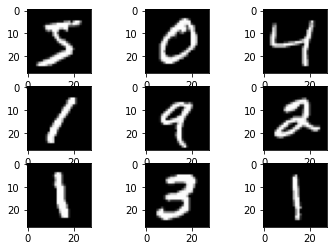

class distribution for training dataset - [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
class distribution for testing dataset - [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]


In [15]:
train_X, test_X, train_y, test_y = load_dataset()

In [16]:
'''
  # perfroms feature scaling on training and test sets
'''
def standardize(train, test):
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')
  
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  return train_norm, test_norm

In [17]:
train_norm, test_norm = standardize(train_X, test_X)

In [18]:
'''
  # creates a 2d CNN
'''
def create_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))

  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))
  
  model.add(tf.keras.layers.Flatten())
  
  model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [19]:
'''
  # evaluates the model using k-fold method
  # data_X - training examples
  # data_y - testing examples
  # n_folds - number of folds
  # returns list of accuracy of models on validation data, list of fitted models, and list of sequential models
'''
def evaluate_model(data_X, data_y, n_folds = 5):
  scores, history, models = list(), list(), list()
  kfold = KFold(n_folds, shuffle = True, random_state = 1)
  for cur_train_X, cur_test_X in kfold.split(data_X):
    model = create_model()
    models.append(model)

    train_X, train_y, test_X, test_y = data_X[cur_train_X], data_y[cur_train_X], data_X[cur_test_X], data_y[cur_test_X]
    history.append(model.fit(train_X, train_y, epochs = 10, batch_size = 32, validation_data = (test_X, test_y)))

    _, acc = model.evaluate(test_X, test_y)
    scores.append(acc)
  return scores, history, models

In [20]:
scores, history, models = evaluate_model(train_norm, train_y)

Epoch 1/10
1500/1500 [==============================] - 39s 26ms/step - loss: 0.1453 - accuracy: 0.9547 - val_loss: 0.0645 - val_accuracy: 0.9804
Epoch 2/10
1500/1500 [==============================] - 39s 26ms/step - loss: 0.0492 - accuracy: 0.9852 - val_loss: 0.0544 - val_accuracy: 0.9833
Epoch 3/10
1500/1500 [==============================] - 40s 27ms/step - loss: 0.0334 - accuracy: 0.9890 - val_loss: 0.0586 - val_accuracy: 0.9841
Epoch 4/10
1500/1500 [==============================] - 39s 26ms/step - loss: 0.0248 - accuracy: 0.9919 - val_loss: 0.0557 - val_accuracy: 0.9825
Epoch 5/10
1500/1500 [==============================] - 40s 27ms/step - loss: 0.0186 - accuracy: 0.9940 - val_loss: 0.0456 - val_accuracy: 0.9862
Epoch 6/10
1500/1500 [==============================] - 40s 27ms/step - loss: 0.0145 - accuracy: 0.9952 - val_loss: 0.0458 - val_accuracy: 0.9876
Epoch 7/10
1500/1500 [==============================] - 40s 26ms/step - loss: 0.0118 - accuracy: 0.9960 - val_loss: 0.0460 -

In [21]:
scores

[0.9886666536331177,
 0.9894999861717224,
 0.9898333549499512,
 0.9914166927337646,
 0.9891666769981384]

In [22]:
'''
  # plots the loss and accuracy for training and validation sets
'''
def plot_learning_curves(history):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  for model in history:
    ax1.set_title('Cross Entropy Loss')
    ax1.plot(model.history['loss'], color = 'blue', label = 'train')
    ax1.plot(model.history['val_loss'], color = 'red', label = 'validation')

    ax2.set_title('Accuracy')
    ax2.plot(model.history['accuracy'], color = 'blue', label = 'train')
    ax2.plot(model.history['val_accuracy'], color = 'red', label = 'validation')
  plt.show()

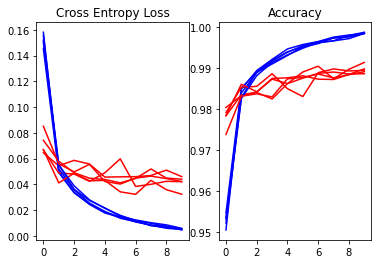

In [23]:
plot_learning_curves(history)

In [24]:
prob_vec_train = models[3].predict(train_norm)
prob_vec_test = models[3].predict(test_norm)

In [25]:
prob_vec_train[0]

array([1.8841200e-15, 9.2646287e-15, 1.3392450e-16, 3.9444308e-06,
       8.9384338e-16, 9.9999607e-01, 1.5998899e-14, 2.8654507e-13,
       5.1386300e-09, 1.5690953e-10], dtype=float32)

In [26]:
prob_vec_test[0]

array([1.1746366e-12, 2.1489277e-11, 1.8845492e-10, 1.6553592e-09,
       4.9971627e-10, 9.8249631e-13, 2.1672683e-16, 1.0000000e+00,
       3.6388236e-11, 7.3155197e-11], dtype=float32)

In [27]:
'''
  # computes entropy for probability vectors
  # prob_vec - probability vector
'''
def cal_entropy(prob_vec):
  entropy = 0
  for prob in prob_vec:
    entropy = entropy + prob * math.log(prob, 2)
  return -1 * entropy

In [28]:
# compute average entropy for probability vector of training examples
entropy_train = list()
sum_prob_vec_train = 0

for prob_vec in prob_vec_train:
  cur_entropy = cal_entropy(prob_vec)
  entropy_train.append(cur_entropy)
  sum_prob_vec_train = sum_prob_vec_train + cur_entropy

avg_train_entropy = sum_prob_vec_train / len(prob_vec_train)
avg_train_entropy

0.010455172774532952

In [29]:
# compute average entropy for probability vector of testing examples
entropy_test = list()
sum_prob_vec_test = 0

for prob_vec in prob_vec_test:
  cur_entropy = cal_entropy(prob_vec)
  entropy_test.append(cur_entropy)
  sum_prob_vec_test = sum_prob_vec_test + cur_entropy

avg_test_entropy = sum_prob_vec_test / len(prob_vec_test)
avg_test_entropy

0.017423615142556942

In [30]:
def cal_auc(train_vec, test_vec, pos_count, neg_count, inc_threshold = 0.1):
  threshold = 0
  tpr_list, fpr_list = list(), list()
  auc = 0

  while(threshold <= 1):
    tp_count = 0
    fp_count = 0

    for val in train_vec:
      if(val >= threshold):
        tp_count += 1

    for val in test_vec:
      if(val >= threshold):
        fp_count += 1

    tpr = tp_count / pos_count
    fpr = fp_count / neg_count

    tpr_list.append(tpr)
    fpr_list.append(fpr)

    threshold += inc_threshold

  for i in range(len(tpr_list) - 1):
    diff_fpr = fpr_list[i] - fpr_list[i + 1]
    sum_tpr = tpr_list[i] + tpr_list[i + 1]
    mul = diff_fpr * sum_tpr / 2
    auc += mul
  
  return auc

In [31]:
cal_auc(entropy_train, entropy_test, len(entropy_train), len(entropy_test), 0.01)

0.49829897749999985